# Randomized K-Fold Cross-validation

This notebook implements randomized k-fold cross-validation, and examines the errors of the model by distance from the training set.

*Note*, these results may differ slightly from those presented in the manuscript, as its fairly difficult to get a consistent random state throughout all the training and validation steps.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.5)
sns.set(color_codes=True)

import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
from ysi_utils.models.setup_model import model

from ysi_utils.data import low
from ysi_utils.descriptors import dragon
from ysi_utils.validation import y_train as y
from ysi_utils.validation import y_test

X = dragon.loc[y.index]
X_test = dragon.loc[y_test.index]

Using Theano backend.


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import median_absolute_error
from sklearn.cross_validation import KFold, cross_val_predict

/Users/pstjohn/anaconda3/envs/ysi/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


*This step takes a long time to run, as it re-fits the model 10 times for each iteration*

In [ ]:
import multiprocessing
multiprocessing.cpu_count()

In [ ]:
np.random.seed(0)

y_cv_predict = [[]] * 25

for i in range(25):
    y_cv_predict[i] = cross_val_predict(model, X.values, y.YSI.values,
                                        cv=KFold(n=len(y), n_folds=10, shuffle=True,
                                                 random_state=i), n_jobs=-1)
# Pickle the CV results
y_cv_df = pd.DataFrame(np.array(y_cv_predict).T, index=y.index)
y_cv_df.to_pickle('y_cv_random_results.p')

Or, load from an existing pickle

In [4]:
y_cv_df = pd.read_pickle('y_cv_random_results.p')

In [5]:
from ysi_utils.models import outlier_model
y['inlier'] = outlier_model.predict(X) == 1

In [6]:
train_dist = outlier_model.decision_function(X)
y_dist = pd.DataFrame((y['YSI'] - y_cv_df.mean(1)).abs(), columns=['YSI'])
y_dist['err'] = y_cv_df.std(1)*1.96
y_dist['dist'] = -train_dist
y_dist['inlier'] = y.inlier

mavg = np.zeros((2, 200))
for i, x_start in enumerate(
    np.linspace(y_dist.dist.min(), .15, 200)):
    
    x_end = x_start + .05
    mavg[0, i] = x_start + .025
    mavg[1, i] = y_dist.loc[
         (y_dist.dist >= x_start) & (y_dist.dist < x_end), 'YSI'].mean()

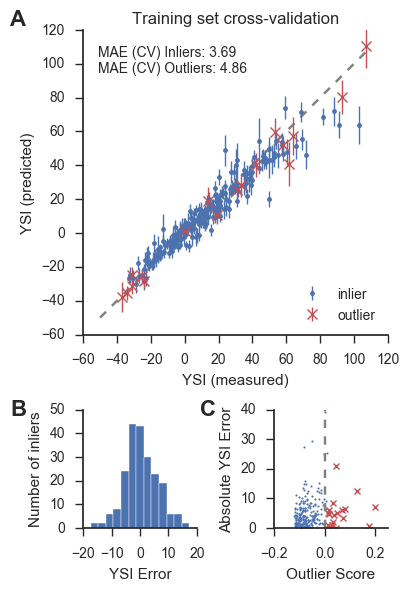

In [10]:
with sns.axes_style('ticks'):
    
    fig = plt.figure(figsize=(4,6))
    gs = gridspec.GridSpec(3,2)
    
    ax = fig.add_subplot(gs[:2,:2], aspect='equal')
    ax2 = fig.add_subplot(gs[2, 0])
    ax3 = fig.add_subplot(gs[2, 1])
    #plt.setp(ax2.get_xticklabels(), visible=False)

    ax.set_xlim([-60, 120])
    ax.set_ylim([-60, 120])

    ax.errorbar(y.loc[y.inlier, 'YSI'], y_cv_df.mean(1)[y.inlier.values],
                fmt='.', label='inlier', lw=1., capsize=0,
                yerr=1.96*y_cv_df[y.inlier.values].std(1))
    ax.errorbar(y.loc[~y.inlier, 'YSI'], y_cv_df.mean(1)[~y.inlier.values],
                fmt='x', color='r', markeredgewidth=1., label='outlier',
                yerr=1.96*y_cv_df[~y.inlier.values].std(1), lw=1., capsize=0)

    ax.plot([-50, 110], [-50, 110], '--', zorder=0, color='gray')
    
    mae_inlier = median_absolute_error(
        y.loc[y.inlier, 'YSI'], y_cv_df.mean(1)[y.inlier.values])
    
    
    
    ax.set_title('Training set cross-validation')
    ax.set_ylabel('YSI (predicted)')
    ax.set_xlabel('YSI (measured)')
    
    text = ('MAE (CV) Inliers: {:.2f}'.format(
            mae_inlier) + '\n' +
            'MAE (CV) Outliers: {:.2f}'.format(
            median_absolute_error(y.loc[~y.inlier, 'YSI'],
                                y_cv_df.mean(1)[~y.inlier.values])))
    
    ax.text(0.05, 0.95, text,
            transform=ax.transAxes, ha='left', va='top')
    
    ax.legend(loc='lower right')
    
    
    #ax2 = fig.add_subplot(122)
    ax2.hist((y.loc[y.inlier, 'YSI'] - y_cv_df.mean(1)[y.inlier.values]),
             bins=15, edgecolor='w', normed=False, range=(-20, 20))

    ax2.set_xlim([-20, 20])
    ax2.set_xticks([-20, -10, 0, 10, 20])
    ax2.set_ylim([0, 50])

    ax2.set_xlabel('YSI Error')
    ax2.set_ylabel('Number of inliers')

    ax3.plot(y_dist.loc[y_dist.inlier, 'dist'], y_dist.loc[y_dist.inlier, 'YSI'], '.',
             markersize=3)
    ax3.plot(y_dist.loc[~y_dist.inlier, 'dist'], y_dist.loc[~y_dist.inlier, 'YSI'],
             'rx', markersize=5., markeredgewidth=1.)
    ax3.plot(train_dist[outlier_model.predict(X) == -1]**(1/3), 
         (y.loc[~y.inlier, 'YSI'] - y_cv_df.mean(1)[~y.inlier.values]).abs(),
         'rx', markersize=4., markeredgewidth=1.)
    
    ax3.axvline(0, ls='--', color='gray')
    
    #plt.legend(loc='upper right')
    ax3.set_ylabel('Absolute YSI Error')
    ax3.set_xlabel(r'Outlier Score')
    
    ax3.set_xlim([-.2, .25])
    ax3.set_yticks(np.arange(0, 50, 10))
    ax3.set_xticks([-.2, 0., .2])
    
    sns.despine()
    fig.tight_layout()

    fig.text(0.0, .975, 'A', va='top', ha='left', fontsize=16, fontweight='bold')
    fig.text(0.0, .325, 'B', va='top', ha='left', fontsize=16, fontweight='bold')
    fig.text(0.475, .325, 'C', va='top', ha='left', fontsize=16, fontweight='bold')
    
    fig.savefig('ysi_crossval.svg', transparent=True)

### Analysis of cross-validation outliers

In [11]:
ycv = y.copy()
ycv['YSI_diff'] = (ycv.YSI - y_cv_df.mean(1))
ycv['YSI(cv)'] = y_cv_df.mean(1)
ycv['YSI(cv_err)'] = 1.96*y_cv_df.std(1)

In [12]:
ycv = ycv[ycv.inlier].copy()
ycv = ycv.sort_values('YSI_diff').drop(
    ['Ref', 'inlier', 'YSI_diff', 'Type'], 1)

In [13]:
ycv.head(10)

,Species,CAS,YSI,YSI(cv),YSI(cv_err)
SMILES,,,,,
C1=CCCCC1,cyclohexene,110-83-8,23.7,48.816883,9.110898
COC1CCCCO1,2-methoxytetrahydropyran,6581-66-4,-12.9,2.181619,9.145402
C=C(C)CC(C)(C)C,"2,4,4-trimethyl-1-pentene",107-39-1,59.2,74.061302,6.971259
CC=C(C)C,2-methyl-2-butene,513-35-9,20.4,33.103073,4.903362
CC1CCCC1,methylcyclopentane,96-37-7,30.9,42.903755,10.453062
CCC1CO1,"1,2-epoxybutane",106-88-7,-17.9,-5.971723,5.488716
CCC1CCCC1,ethylcyclopentane,1640-89-7,43.8,54.633961,13.129497
CCCCCCC(=O)OC,methyl heptanoate,106-73-0,3.3,13.107208,4.223814
COC(C)(OC)OC,"1,1,1-trimethoxyethane",1445-45-0,-27.5,-17.705420,4.342262


In [14]:
ycv.tail(10)[::-1]

,Species,CAS,YSI,YSI(cv),YSI(cv_err)
SMILES,,,,,
CC1=CCCC1,1-methylcyclopentene,693-89-0,102.7,63.667564,11.138880
COC1CCCC1,methyl cyclopentyl ether,5614-37-9,49.6,20.147734,4.788744
CC(C)=CC(C)(C)C,"2,4,4-trimethyl-2-pentene",107-40-4,91.4,64.029732,8.027209
C1=CCCCCC1,cycloheptene,628-92-2,71.6,46.242435,8.639507
CC(C)=C(C)C(C)C,"2,3,4-trimethyl-2-pentene",565-77-5,87.9,71.874557,8.474607
CCC(C)OC(C)CC,sec-butyl ether,6863-58-7,36.6,21.828070,4.415872
C=C(C)C(C)(C)C,"2,3,3-trimethyl-1-butene",594-56-9,65.9,51.572617,7.796319
CCCCCOC(C)=O,pentyl acetate,628-63-7,15.6,1.975592,3.615796
C=CCCCCCCCC,1-decene,872-05-9,69.0,55.395443,6.303191


Write structure files to generate SVG images from openbabel

In [ ]:
with open('structures/over.smi', 'w') as f:
    for smiles, row in ycv.head().iterrows():
        f.write('{0} {1}\n'.format(smiles, row.Species))
        
with open('structures/under.smi', 'w') as f:
    for smiles, row in ycv.tail()[::-1].iterrows():
        f.write('{0} {1}\n'.format(smiles, row.Species))

In [12]:
ycv.reset_index(drop=True).set_index('Species').loc[low.Species].dropna().reset_index().to_csv('cv_results.csv')